# Style transfer Methods, A review

### A Neural Algorithm of Artistic Style
Source: https://harishnarayanan.org/writing/artistic-style-transfer/

Using VGG16 (or 19) and a gramm matrix to solve an optimization problem

In [26]:
# Imports
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

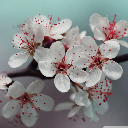

In [27]:
image_size = 128
images_path = "C:/Users/Acer/Documents/GitHub/style_transfer_2018"
# Load a content image
content_image = Image.open(images_path+"/content_images/006.jpg").resize((image_size, image_size))
style_image = Image.open(images_path+"/style_images/03.jpg").resize((image_size, image_size))
content_image.resize((128,128)) # Resize just to see it at a smaller size

(128, 128, 3)


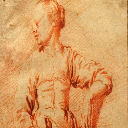

In [28]:
content_mat = np.array(content_image.convert('RGB'))
print(content_mat.shape)
#print(content_mat)
#print(content_mat.dtype)
style_image

In [29]:
# Transforming into numeric information
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)

red_mean = 103.939
green_mean = 116.779
blue_mean = 123.68

content_array[:,:,:,0] -= red_mean
content_array[:,:,:,1] -= green_mean
content_array[:,:,:,2] -= blue_mean
content_array = content_array[:,:,:,::-1]
style_array[:,:,:,0] -= red_mean
style_array[:,:,:,1] -= green_mean
style_array[:,:,:,2] -= blue_mean
style_array = style_array[:,:,:,::-1]

print(content_array.shape, style_array.shape)

(1, 128, 128, 3) (1, 128, 128, 3)


In [30]:
#Defining our loss functions
def content_loss(content, combination):
    return tf.reduce_sum(tf.square(content-combination))

def gram_matrix(x): # Hay que entenderla bien
    features = tf.keras.backend.batch_flatten(tf.keras.backend.permute_dimensions(x, (2, 0, 1)))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination): # Tambien
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    return tf.reduce_sum(tf.square(S - C)) / (4. * (channels ** 2) * (image_size ** 4))

def total_variation_loss(x):
    a = tf.square(x[:, :image_size-1, :image_size-1, :] - x[:, 1:, :image_size-1, :])
    b = tf.square(x[:, :image_size-1, :image_size-1, :] - x[:, :image_size-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [31]:
# Start creating the main graph
content_node = tf.constant(content_array, name = "content_image", dtype=tf.float32)
style_node = tf.constant(style_array, name = "style_image", dtype=tf.float32)
combination_image = tf.Variable(tf.random_uniform(shape=[1,image_size, image_size,3], minval = -1, maxval= 1), dtype=tf.float32)
input_ten = tf.concat([content_node, style_node, combination_image], axis = 0)

In [32]:
# Importing the VGG16 pre-trained net to use it on the content loss
vgg = tf.keras.applications.VGG16(include_top = False, weights = "imagenet", input_tensor = input_ten)

In [33]:
layers = dict([(layer.name, layer.output) for layer in vgg.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 128, 128, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 128, 128, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 64, 64, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 64, 64, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 64, 64, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 32, 32, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_2/MaxPool:0' shape=(3, 16, 16, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_2/Relu:0' shape=(3, 16, 16, 512) dtype=float

In [34]:
# Continue with the graph
content_weight = 0.020
style_weight = 100
total_variation_weight = 2*(10**-5)

content_reference_layer = "block2_conv2"
style_reference_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

loss = tf.Variable(0, name = "total_loss", dtype=tf.float32)

content_feature_layer = layers[content_reference_layer]
loss = loss + content_weight * content_loss(content_feature_layer[0,:,:,:], content_feature_layer[2,:,:,:])

for layer in style_reference_layers:
    style_feature_layers = layers[layer]
    #print(style_feature_layers)
    A = style_feature_layers [1, :, :, :] #Estilo
    B = style_feature_layers [2, :, :, :] #combinada
    loss = loss + style_loss(A, B)*style_weight/len(style_reference_layers)

loss = loss + total_variation_weight * total_variation_loss(combination_image)

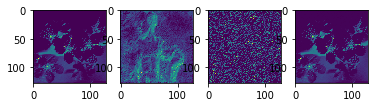

116290950.0


In [35]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.subplot(1,4,1)
    plt.imshow(layers['block1_conv1'][0,:,:,50].eval()) #Contenido
    plt.subplot(1,4,2)
    plt.imshow(layers['block1_conv1'][1,:,:,50].eval()) 
    plt.subplot(1,4,3)
    plt.imshow(layers['block1_conv1'][2,:,:,50].eval())
    plt.subplot(1,4,4)
    plt.imshow(layers['block1_conv1'][0,:,:,50].eval()-layers['block1_conv1'][2,:,:,50].eval()) #Resta de las anteriores
    plt.show()
    print(content_loss((layers['block1_conv1'][0,:,:,:].eval()), (layers['block1_conv1'][2,:,:,:].eval())).eval())

In [36]:
# implementing L-BFGS-B from scipy
def _loss(loss_evaled):
    print(loss_evaled)
    
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, var_list = [combination_image], 
                                                   var_to_bounds={combination_image:(-150,200)}, method = "L-BFGS-B", options = {"maxiter":45})
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    optimizer.minimize(sess, loss_callback = _loss, fetches =[loss])
    final_image = combination_image.eval()

24268328.0
24266524.0
24263982.0
24249578.0
24124600.0
22600740.0
18609738.0
16533806.0
13964606.0
11120435.0
5016228.5
4108617.5
2800459.0
1789354.1
1278832.5
965291.5
773475.75
585462.44
440795.28
389552.97
332795.66
238995.69
168782.83
132474.33
115310.07
102438.43
97819.56
95602.5
94055.63
92695.13
90355.266
87194.42
87264.33
85744.18
84296.88
83096.2
81710.086
80625.234
79294.375
78035.78
77205.77
75995.42
74875.35
73837.34
73099.6
72520.375
71822.836
71468.45
70992.586
70586.63
70224.28
69744.36
69202.68
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 69202.679688
  Number of iterations: 46
  Number of functions evaluations: 53


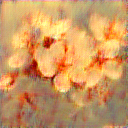

In [37]:
final_image = final_image.reshape((image_size, image_size, 3))
final_image_b = final_image
final_image = final_image[:,:,::-1]
final_image[:,:,0] += red_mean
final_image[:,:,1] += green_mean
final_image[:,:,2] += blue_mean
final_image = np.clip(final_image, 0, 255).astype("uint8")
Image.fromarray(final_image)

45232268.0


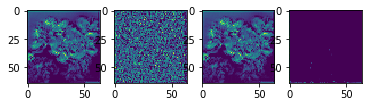

Error a la iteracion  0 :  44924948.0
Error a la iteracion  1 :  43062772.0
Error a la iteracion  2 :  39417444.0
Error a la iteracion  3 :  34780250.0
Error a la iteracion  4 :  29883712.0
Error a la iteracion  5 :  25210228.0
Error a la iteracion  6 :  21034228.0
Error a la iteracion  7 :  17484142.0
Error a la iteracion  8 :  14582410.0
Error a la iteracion  9 :  12281983.0
Error a la iteracion  10 :  10493317.0
Error a la iteracion  11 :  9111845.0
Error a la iteracion  12 :  8038060.0
Error a la iteracion  13 :  7186814.0
Error a la iteracion  14 :  6492711.5
Error a la iteracion  15 :  5909975.0
Error a la iteracion  16 :  5407748.5
Error a la iteracion  17 :  4966745.5
Error a la iteracion  18 :  4573521.5
Error a la iteracion  19 :  4219336.0
Error a la iteracion  20 :  3898675.2
Error a la iteracion  21 :  3606864.8
Error a la iteracion  22 :  3340648.2
Error a la iteracion  23 :  3097149.8
Error a la iteracion  24 :  2874177.8
Error a la iteracion  25 :  2669842.2
Error a la 

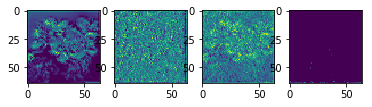

Error a la iteracion  50 :  614056.75
Error a la iteracion  51 :  589372.1
Error a la iteracion  52 :  566445.7
Error a la iteracion  53 :  545142.2
Error a la iteracion  54 :  525323.06
Error a la iteracion  55 :  506866.94
Error a la iteracion  56 :  489655.4
Error a la iteracion  57 :  473606.7
Error a la iteracion  58 :  458626.88
Error a la iteracion  59 :  444642.25
Error a la iteracion  60 :  431565.84
Error a la iteracion  61 :  419330.16
Error a la iteracion  62 :  407864.62
Error a la iteracion  63 :  397099.53
Error a la iteracion  64 :  386985.72
Error a la iteracion  65 :  377476.28
Error a la iteracion  66 :  368532.8
Error a la iteracion  67 :  360111.44
Error a la iteracion  68 :  352181.34
Error a la iteracion  69 :  344707.06
Error a la iteracion  70 :  337652.34
Error a la iteracion  71 :  330982.12
Error a la iteracion  72 :  324667.2
Error a la iteracion  73 :  318687.4
Error a la iteracion  74 :  313025.1
Error a la iteracion  75 :  307658.6
Error a la iteracion  

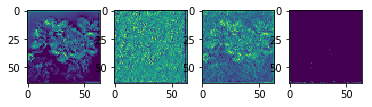

Error a la iteracion  100 :  230826.12
Error a la iteracion  101 :  229110.02
Error a la iteracion  102 :  227453.45
Error a la iteracion  103 :  225854.92
Error a la iteracion  104 :  224312.34
Error a la iteracion  105 :  222823.28
Error a la iteracion  106 :  221384.44
Error a la iteracion  107 :  219993.6
Error a la iteracion  108 :  218648.84
Error a la iteracion  109 :  217346.45
Error a la iteracion  110 :  216085.62
Error a la iteracion  111 :  214864.72
Error a la iteracion  112 :  213683.22
Error a la iteracion  113 :  212537.9
Error a la iteracion  114 :  211426.69
Error a la iteracion  115 :  210348.97
Error a la iteracion  116 :  209303.42
Error a la iteracion  117 :  208289.14
Error a la iteracion  118 :  207304.14
Error a la iteracion  119 :  206347.06
Error a la iteracion  120 :  205417.05
Error a la iteracion  121 :  204512.6
Error a la iteracion  122 :  203632.27
Error a la iteracion  123 :  202775.56
Error a la iteracion  124 :  201942.19
Error a la iteracion  125 : 

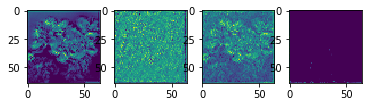

Error a la iteracion  150 :  186004.0
Error a la iteracion  151 :  185551.56
Error a la iteracion  152 :  185107.5
Error a la iteracion  153 :  184670.86
Error a la iteracion  154 :  184242.12
Error a la iteracion  155 :  183820.8
Error a la iteracion  156 :  183407.16
Error a la iteracion  157 :  183001.06
Error a la iteracion  158 :  182601.97
Error a la iteracion  159 :  182209.75
Error a la iteracion  160 :  181823.73
Error a la iteracion  161 :  181443.78
Error a la iteracion  162 :  181070.23
Error a la iteracion  163 :  180702.89
Error a la iteracion  164 :  180341.28
Error a la iteracion  165 :  179985.22
Error a la iteracion  166 :  179634.67
Error a la iteracion  167 :  179289.6
Error a la iteracion  168 :  178950.02
Error a la iteracion  169 :  178615.22
Error a la iteracion  170 :  178285.25
Error a la iteracion  171 :  177960.31
Error a la iteracion  172 :  177640.16
Error a la iteracion  173 :  177324.78
Error a la iteracion  174 :  177013.77
Error a la iteracion  175 :  

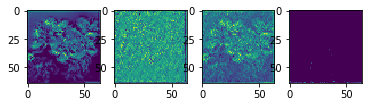

Error a la iteracion  200 :  170149.08
Error a la iteracion  201 :  169922.62
Error a la iteracion  202 :  169698.06
Error a la iteracion  203 :  169475.78
Error a la iteracion  204 :  169255.89
Error a la iteracion  205 :  169038.11
Error a la iteracion  206 :  168822.34
Error a la iteracion  207 :  168608.83
Error a la iteracion  208 :  168397.17
Error a la iteracion  209 :  168187.5
Error a la iteracion  210 :  167979.53
Error a la iteracion  211 :  167773.38
Error a la iteracion  212 :  167569.31
Error a la iteracion  213 :  167367.16
Error a la iteracion  214 :  167166.69
Error a la iteracion  215 :  166967.78
Error a la iteracion  216 :  166770.17
Error a la iteracion  217 :  166574.4
Error a la iteracion  218 :  166380.12
Error a la iteracion  219 :  166187.81
Error a la iteracion  220 :  165996.89
Error a la iteracion  221 :  165807.23
Error a la iteracion  222 :  165619.03
Error a la iteracion  223 :  165432.55
Error a la iteracion  224 :  165247.33
Error a la iteracion  225 :

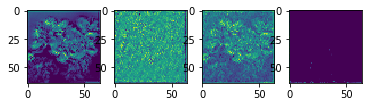

Error a la iteracion  250 :  160885.45
Error a la iteracion  251 :  160733.02
Error a la iteracion  252 :  160581.33
Error a la iteracion  253 :  160430.72
Error a la iteracion  254 :  160280.97
Error a la iteracion  255 :  160132.02
Error a la iteracion  256 :  159983.94
Error a la iteracion  257 :  159836.75
Error a la iteracion  258 :  159690.36
Error a la iteracion  259 :  159545.06
Error a la iteracion  260 :  159400.28
Error a la iteracion  261 :  159256.47
Error a la iteracion  262 :  159113.42
Error a la iteracion  263 :  158971.05
Error a la iteracion  264 :  158829.47
Error a la iteracion  265 :  158688.53
Error a la iteracion  266 :  158548.02
Error a la iteracion  267 :  158408.23
Error a la iteracion  268 :  158269.25
Error a la iteracion  269 :  158131.17
Error a la iteracion  270 :  157993.39
Error a la iteracion  271 :  157856.36
Error a la iteracion  272 :  157720.06
Error a la iteracion  273 :  157584.55
Error a la iteracion  274 :  157449.8
Error a la iteracion  275 

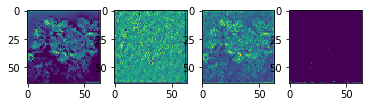

Error a la iteracion  300 :  154169.77
Error a la iteracion  301 :  154051.55
Error a la iteracion  302 :  153933.81
Error a la iteracion  303 :  153816.78
Error a la iteracion  304 :  153700.2
Error a la iteracion  305 :  153583.88
Error a la iteracion  306 :  153468.03
Error a la iteracion  307 :  153352.98
Error a la iteracion  308 :  153238.39
Error a la iteracion  309 :  153124.34
Error a la iteracion  310 :  153011.0
Error a la iteracion  311 :  152897.9
Error a la iteracion  312 :  152785.36
Error a la iteracion  313 :  152673.14
Error a la iteracion  314 :  152561.31
Error a la iteracion  315 :  152449.94
Error a la iteracion  316 :  152339.02
Error a la iteracion  317 :  152228.33
Error a la iteracion  318 :  152118.08
Error a la iteracion  319 :  152008.4
Error a la iteracion  320 :  151899.1
Error a la iteracion  321 :  151790.06
Error a la iteracion  322 :  151681.64
Error a la iteracion  323 :  151573.64
Error a la iteracion  324 :  151465.98
Error a la iteracion  325 :  1

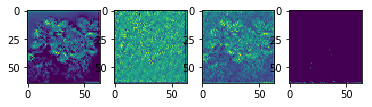

Error a la iteracion  350 :  148792.78
Error a la iteracion  351 :  148694.62
Error a la iteracion  352 :  148596.77
Error a la iteracion  353 :  148499.33
Error a la iteracion  354 :  148402.19
Error a la iteracion  355 :  148305.34
Error a la iteracion  356 :  148208.78
Error a la iteracion  357 :  148112.64
Error a la iteracion  358 :  148016.61
Error a la iteracion  359 :  147920.94
Error a la iteracion  360 :  147825.31
Error a la iteracion  361 :  147730.17
Error a la iteracion  362 :  147635.33
Error a la iteracion  363 :  147540.56
Error a la iteracion  364 :  147446.08
Error a la iteracion  365 :  147351.95
Error a la iteracion  366 :  147257.89
Error a la iteracion  367 :  147164.36
Error a la iteracion  368 :  147071.0
Error a la iteracion  369 :  146977.8
Error a la iteracion  370 :  146884.86
Error a la iteracion  371 :  146792.31
Error a la iteracion  372 :  146699.9
Error a la iteracion  373 :  146607.86
Error a la iteracion  374 :  146515.95
Error a la iteracion  375 : 

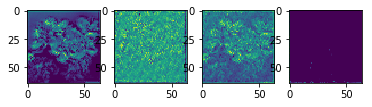

Error a la iteracion  400 :  144216.94
Error a la iteracion  401 :  144131.33
Error a la iteracion  402 :  144046.0
Error a la iteracion  403 :  143960.89
Error a la iteracion  404 :  143876.0
Error a la iteracion  405 :  143791.42
Error a la iteracion  406 :  143707.12
Error a la iteracion  407 :  143622.86
Error a la iteracion  408 :  143538.86
Error a la iteracion  409 :  143454.9
Error a la iteracion  410 :  143371.31
Error a la iteracion  411 :  143287.89
Error a la iteracion  412 :  143204.5
Error a la iteracion  413 :  143121.48
Error a la iteracion  414 :  143038.48
Error a la iteracion  415 :  142955.66
Error a la iteracion  416 :  142872.95
Error a la iteracion  417 :  142790.5
Error a la iteracion  418 :  142708.19
Error a la iteracion  419 :  142626.1
Error a la iteracion  420 :  142544.22
Error a la iteracion  421 :  142462.4
Error a la iteracion  422 :  142381.02
Error a la iteracion  423 :  142299.58
Error a la iteracion  424 :  142218.47
Error a la iteracion  425 :  142

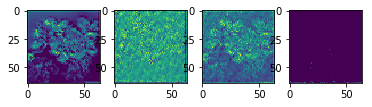

Error a la iteracion  450 :  140171.97
Error a la iteracion  451 :  140095.44
Error a la iteracion  452 :  140019.1
Error a la iteracion  453 :  139942.73
Error a la iteracion  454 :  139866.66
Error a la iteracion  455 :  139790.9
Error a la iteracion  456 :  139715.3
Error a la iteracion  457 :  139639.86
Error a la iteracion  458 :  139564.62
Error a la iteracion  459 :  139489.44
Error a la iteracion  460 :  139414.2
Error a la iteracion  461 :  139339.61
Error a la iteracion  462 :  139265.05
Error a la iteracion  463 :  139190.52
Error a la iteracion  464 :  139116.08
Error a la iteracion  465 :  139041.94
Error a la iteracion  466 :  138967.83
Error a la iteracion  467 :  138893.86
Error a la iteracion  468 :  138819.98
Error a la iteracion  469 :  138746.33
Error a la iteracion  470 :  138672.72
Error a la iteracion  471 :  138599.52
Error a la iteracion  472 :  138526.28
Error a la iteracion  473 :  138453.16
Error a la iteracion  474 :  138380.4
Error a la iteracion  475 :  1

In [38]:
# Training
   
learning_rate = 10
optimizer = tf.train.AdagradOptimizer(learning_rate)

gradients = optimizer.compute_gradients(loss, var_list=[combination_image])
train_step = optimizer.apply_gradients(gradients)

n_iterations = 500
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start_image = combination_image.eval()
    print(loss.eval())
    for i in range(n_iterations):
        if i%50 == 0:
            plt.figure(i)
            plt.subplot(1,4,1)
            plt.imshow(layers[content_reference_layer][0,:,:,40].eval())
            plt.subplot(1,4,2)
            plt.imshow(layers[content_reference_layer][2,:,:,40].eval())
            plt.subplot(1,4,3)
            plt.imshow(layers[content_reference_layer][0,:,:,40].eval()-layers[content_reference_layer][2,:,:,40].eval())
            plt.subplot(1,4,4)
            plt.imshow(layers[content_reference_layer][1,:,:,50].eval())
            plt.show()
        sess.run(train_step)
        print("Error a la iteracion ", i, ": ", loss.eval())
        
    final_image = combination_image.eval()
    print(final_image)

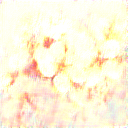

In [39]:
final_image = final_image_b[:,:,::-1]
final_image[:,:,0] += red_mean
final_image[:,:,1] += green_mean
final_image[:,:,2] += blue_mean
final_image = np.clip(final_image, 0, 255).astype("uint8")
Image.fromarray(final_image)